In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook we calculate `Percent Replicating` to measure of the proportion of perturbations with detectable signature. The following are the steps taken
1. Normalized, feature selected ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe, for each time point and cell line.
2. Negative control and empty wells are removed from the dataframe.
3. The signal distribution, which is the median pairwise replicate correlation, is computed for each replicate.
4. The null distribution, which is the median pairwise correlation of non-replicates, is computed for 1000 combinations of non-replicates.
5. Percent Replicating is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution
6. The signal and noise distributions and the Percent Replicating values are plotted and the table of Percent Replicating is printed.

In [2]:
n_samples = 1000
n_replicates = 4

corr_replicating_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

In [3]:
for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query("Perturbation==@modality")
    for cell in modality_df.Cell_type.unique():
        cell_df = modality_df.query('Cell_type==@cell')
        for time_point in cell_df.Time.unique():
            time_df = cell_df.query("Time==@time_point")
            all_plates_df = pd.DataFrame()
            for plate in time_df.Assay_Plate_Barcode.unique():
                data_df = utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                all_plates_df = utils.concat_profiles(all_plates_df, data_df)

            all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

            replicating_corr = list(utils.corr_between_replicates(all_plates_df, group_by_feature))
            null_replicating = list(utils.corr_between_non_replicates(all_plates_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name = group_by_feature))

            prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicating_corr, how='right')

            corr_replicating_df = corr_replicating_df.append({'Description':f'{modality}_{cell}_{time_point}',
                                                              'Modality':f'{modality}',
                                                              'Cell':f'{cell}',
                                                              'time':f'{time_point}',
                                                              'Replicating':replicating_corr,
                                                              'Null_Replicating':null_replicating,
                                                              'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                              'Value_95':value_95_replicating}, ignore_index=True)

In [4]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description      |   Percent_Replicating |
|:-----------------|----------------------:|
| compound_A549_24 |                  87.6 |
| compound_A549_48 |                  95.1 |
| compound_U2OS_24 |                  80.1 |
| compound_U2OS_48 |                  74.5 |
| crispr_U2OS_144  |                  62.3 |
| crispr_U2OS_96   |                  72.8 |
| crispr_A549_144  |                  41   |
| crispr_A549_96   |                  42   |
| orf_A549_96      |                  28.7 |
| orf_A549_48      |                  35.6 |
| orf_U2OS_48      |                  52.5 |
| orf_U2OS_96      |                  42.5 |


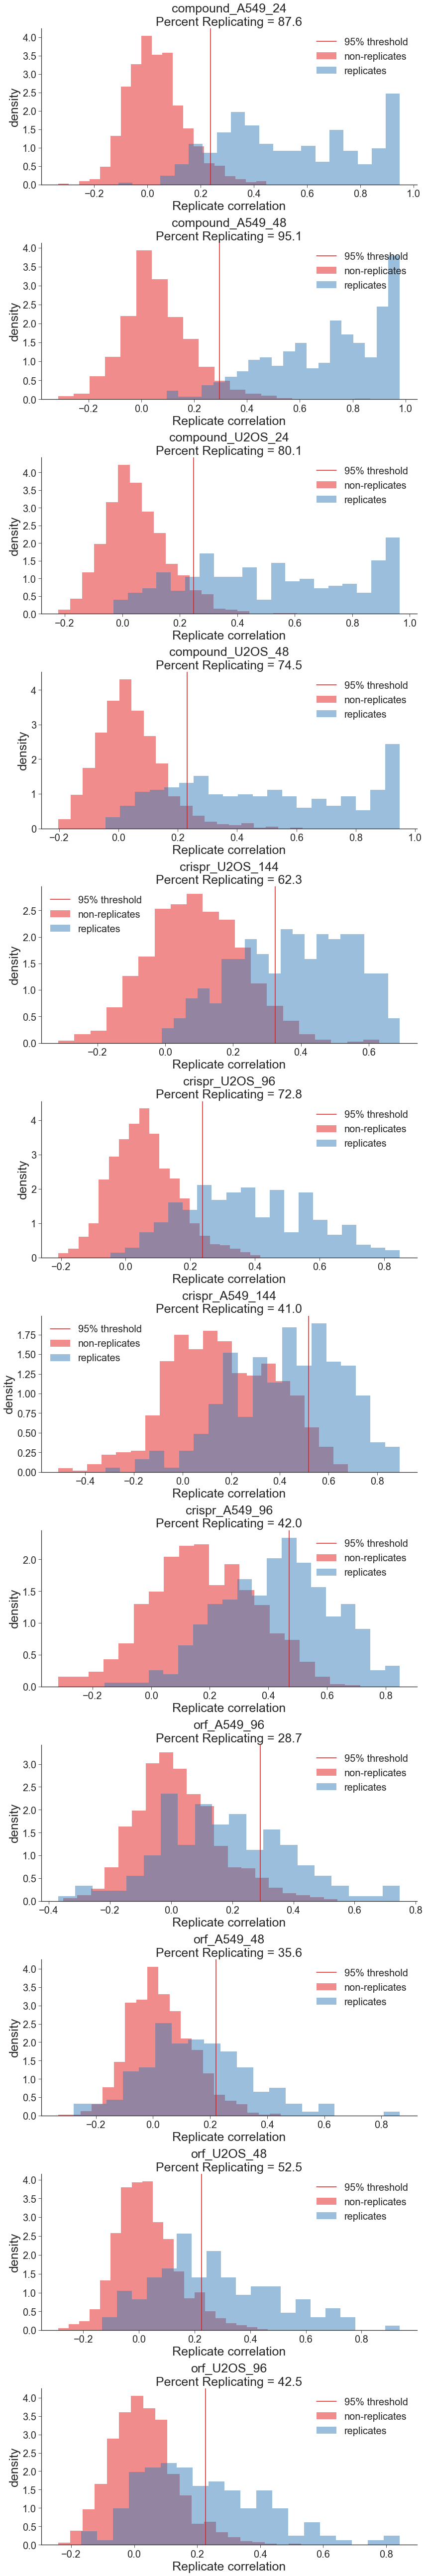

In [5]:
utils.distribution_plot(df=corr_replicating_df, output_file="1.percent_replicating.png", metric="Percent Replicating")

In [6]:
corr_replicating_df['Percent_Replicating'] = corr_replicating_df['Percent_Replicating'].astype(float)

corr_replicating_df.loc[(corr_replicating_df.Modality=='compound') & (corr_replicating_df.time=='24'), 'time'] = 'short'
corr_replicating_df.loc[(corr_replicating_df.Modality=='compound') & (corr_replicating_df.time=='48'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='crispr') & (corr_replicating_df.time=='96'), 'time'] = 'short'
corr_replicating_df.loc[(corr_replicating_df.Modality=='crispr') & (corr_replicating_df.time=='144'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='orf') & (corr_replicating_df.time=='48'), 'time'] = 'short'
corr_replicating_df.loc[(corr_replicating_df.Modality=='orf') & (corr_replicating_df.time=='96'), 'time'] = 'long'

plot_corr_replicating_df = (
    corr_replicating_df.rename(columns={'Modality':'Perturbation'})
    .drop(columns=['Null_Replicating','Value_95','Replicating'])
)

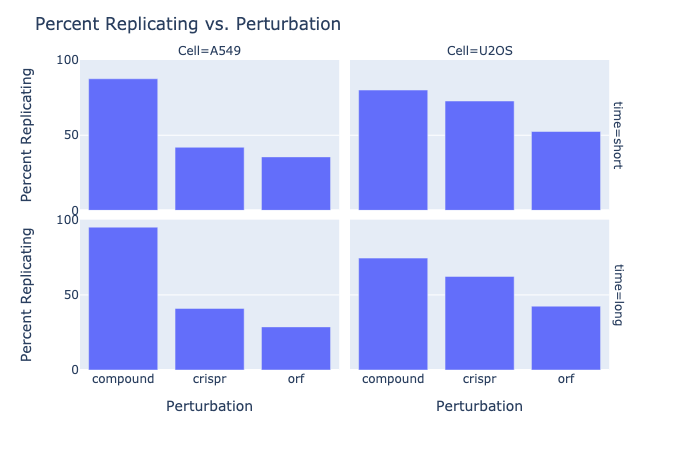

In [7]:
fig = px.bar(data_frame=plot_corr_replicating_df,
             x='Perturbation',
             y='Percent_Replicating',
             facet_row='time',
             facet_col='Cell')
fig.update_layout(title='Percent Replicating vs. Perturbation',
                  yaxis=dict(title='Percent Replicating'),
                  yaxis3=dict(title='Percent Replicating'))
fig.show("png")
fig.write_image(f'figures/1.percent_replicating_facet.png', width=640, height=480, scale=2)

In [8]:
print(plot_corr_replicating_df[['Description','Perturbation','time', 'Cell' ,'Percent_Replicating']].to_markdown(index=False))

| Description      | Perturbation   | time   | Cell   |   Percent_Replicating |
|:-----------------|:---------------|:-------|:-------|----------------------:|
| compound_A549_24 | compound       | short  | A549   |                  87.6 |
| compound_A549_48 | compound       | long   | A549   |                  95.1 |
| compound_U2OS_24 | compound       | short  | U2OS   |                  80.1 |
| compound_U2OS_48 | compound       | long   | U2OS   |                  74.5 |
| crispr_U2OS_144  | crispr         | long   | U2OS   |                  62.3 |
| crispr_U2OS_96   | crispr         | short  | U2OS   |                  72.8 |
| crispr_A549_144  | crispr         | long   | A549   |                  41   |
| crispr_A549_96   | crispr         | short  | A549   |                  42   |
| orf_A549_96      | orf            | long   | A549   |                  28.7 |
| orf_A549_48      | orf            | short  | A549   |                  35.6 |
| orf_U2OS_48      | orf            | sh

In [9]:
plot_corr_replicating_df['feature_set'] = 'CellProfiler'
plot_corr_replicating_df.to_csv('output/cellprofiler_percent_replicating.csv', index=False)